This UFC project takes fight data from 1993 to 2023 and utilizes various machine learning models to predict the probabilities of future fights.

In [687]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [688]:
df = pd.read_csv('./data/raw_total_fight_data.csv', sep = ';') # ; For fixing formatting

In [689]:
df.head()

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,R_TD,B_TD,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_REV,B_REV,R_CTRL,B_CTRL,R_HEAD,B_HEAD,R_BODY,B_BODY,R_LEG,B_LEG,R_DISTANCE,B_DISTANCE,R_CLINCH,B_CLINCH,R_GROUND,B_GROUND,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner
0,Themba Gorimbo,Niko Price,0,0,68 of 127,16 of 53,53%,30%,141 of 223,58 of 100,7 of 9,0 of 3,77%,0%,2,1,0,0,9:14,1:00,44 of 97,13 of 43,9 of 15,2 of 5,15 of 15,1 of 5,43 of 85,11 of 48,6 of 13,5 of 5,19 of 29,0 of 0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,"October 12, 2024","Las Vegas, Nevada, USA",Welterweight Bout,Themba Gorimbo
1,CJ Vergara,Ramazan Temirov,0,3,4 of 16,23 of 55,25%,41%,4 of 16,23 of 55,0 of 0,0 of 0,---,---,0,0,0,0,0:00,0:05,1 of 12,18 of 46,1 of 1,4 of 8,2 of 3,1 of 1,4 of 16,20 of 50,0 of 0,0 of 0,0 of 0,3 of 5,KO/TKO,1,2:50,3 Rnd (5-5-5),Jason Herzog,"October 12, 2024","Las Vegas, Nevada, USA",Flyweight Bout,Ramazan Temirov
2,Brad Tavares,JunYong Park,0,0,65 of 149,99 of 177,43%,55%,73 of 159,124 of 210,0 of 0,2 of 6,---,33%,0,0,0,0,0:42,6:32,55 of 136,76 of 151,2 of 3,4 of 6,8 of 10,19 of 20,62 of 143,91 of 167,0 of 1,3 of 5,3 of 5,5 of 5,Decision - Split,3,5:00,3 Rnd (5-5-5),NaN,"October 12, 2024","Las Vegas, Nevada, USA",Middleweight Bout,JunYong Park
3,Jonathan Pearce,Pat Sabatini,0,0,2 of 2,3 of 5,100%,60%,32 of 32,19 of 25,0 of 0,2 of 3,---,66%,0,1,0,0,0:00,3:56,0 of 0,2 of 4,1 of 1,1 of 1,1 of 1,0 of 0,2 of 2,1 of 2,0 of 0,1 of 1,0 of 0,1 of 2,Submission,1,4:06,3 Rnd (5-5-5),Chris Tognoni,"October 12, 2024","Las Vegas, Nevada, USA",Featherweight Bout,Pat Sabatini
4,Brandon Royval,Tatsuro Taira,0,0,124 of 232,42 of 99,53%,42%,172 of 287,80 of 143,3 of 3,6 of 15,100%,40%,3,1,2,0,2:23,12:13,114 of 216,34 of 91,10 of 16,5 of 5,0 of 0,3 of 3,97 of 203,38 of 93,11 of 12,0 of 1,16 of 17,4 of 5,Decision - Split,5,5:00,5 Rnd (5-5-5-5-5),Jason Herzog,"October 12, 2024","Las Vegas, Nevada, USA",Flyweight Bout,Brandon Royval


In [690]:
df.shape

(7853, 41)

# **Data Cleaning**

We drop columns that are not relevant to our models and rename abreviations to its full definition

In [691]:
to_drop = ['R_REV','B_REV','R_HEAD', 'B_HEAD', 'R_BODY', 'B_BODY', 'R_LEG', 'B_LEG', 'R_DISTANCE', 'B_DISTANCE', 'R_CLINCH', 'B_CLINCH']
df = df.drop(to_drop, axis=1)

In [692]:
to_drop2 = ['Referee','location']
df = df.drop(to_drop2, axis=1)

In [693]:
df['Format'] = df['Format'].str.extract(r'(\d+)')
df = df.rename(columns={'Format': 'No_of_rounds'})
df = df.rename(columns={'R_KD': 'R_Knockdown'})
df = df.rename(columns={'B_KD': 'B_Knockdown'})

In [694]:
df = df.rename(columns={'R_SIG_STR.': 'R_Significant_Strikes'})
df = df.rename(columns={'B_SIG_STR.': 'B_Significant_Strikes'})

df = df.rename(columns={'R_SIG_STR_pct': 'R_Significant_Strike_Percent'})
df = df.rename(columns={'B_SIG_STR_pct': 'B_Significant_Strike_Percent'})

In [695]:
df = df.rename(columns={'R_TOTAL_STR.': 'R_Total_Strikes'})
df = df.rename(columns={'B_TOTAL_STR.': 'B_Total_Strikes'})

In [696]:
df = df.rename(columns={'R_TD': 'R_Takedowns'})
df = df.rename(columns={'B_TD': 'B_Takedowns'})

In [697]:
df = df.rename(columns={'R_TD_pct': 'R_Takedown_Percent'})
df = df.rename(columns={'B_TD_pct': 'B_Takedown_Percent'})

In [698]:
df = df.rename(columns={'R_SUB_ATT': 'R_Submission_Attempt'})
df = df.rename(columns={'B_SUB_ATT': 'B_Submission_Attempt'})

In [699]:
df = df.rename(columns={'R_CTRL': 'R_Ground_Control'})
df = df.rename(columns={'B_CTRL': 'B_Ground_Control'})

In [700]:
df = df.rename(columns={'R_GROUND': 'R_Ground_Strikes'})
df = df.rename(columns={'B_GROUND': 'B_Ground_Strikes'})

In [701]:
df.head()

,R_fighter,B_fighter,R_Knockdown,B_Knockdown,R_Significant_Strikes,B_Significant_Strikes,R_Significant_Strike_Percent,B_Significant_Strike_Percent,R_Total_Strikes,B_Total_Strikes,R_Takedowns,B_Takedowns,R_Takedown_Percent,B_Takedown_Percent,R_Submission_Attempt,B_Submission_Attempt,R_Ground_Control,B_Ground_Control,R_Ground_Strikes,B_Ground_Strikes,win_by,last_round,last_round_time,No_of_rounds,date,Fight_type,Winner
0,Themba Gorimbo,Niko Price,0,0,68 of 127,16 of 53,53%,30%,141 of 223,58 of 100,7 of 9,0 of 3,77%,0%,2,1,9:14,1:00,19 of 29,0 of 0,Decision - Unanimous,3,5:00,3,"October 12, 2024",Welterweight Bout,Themba Gorimbo
1,CJ Vergara,Ramazan Temirov,0,3,4 of 16,23 of 55,25%,41%,4 of 16,23 of 55,0 of 0,0 of 0,---,---,0,0,0:00,0:05,0 of 0,3 of 5,KO/TKO,1,2:50,3,"October 12, 2024",Flyweight Bout,Ramazan Temirov
2,Brad Tavares,JunYong Park,0,0,65 of 149,99 of 177,43%,55%,73 of 159,124 of 210,0 of 0,2 of 6,---,33%,0,0,0:42,6:32,3 of 5,5 of 5,Decision - Split,3,5:00,3,"October 12, 2024",Middleweight Bout,JunYong Park
3,Jonathan Pearce,Pat Sabatini,0,0,2 of 2,3 of 5,100%,60%,32 of 32,19 of 25,0 of 0,2 of 3,---,66%,0,1,0:00,3:56,0 of 0,1 of 2,Submission,1,4:06,3,"October 12, 2024",Featherweight Bout,Pat Sabatini
4,Brandon Royval,Tatsuro Taira,0,0,124 of 232,42 of 99,53%,42%,172 of 287,80 of 143,3 of 3,6 of 15,100%,40%,3,1,2:23,12:13,16 of 17,4 of 5,Decision - Split,5,5:00,5,"October 12, 2024",Flyweight Bout,Brandon Royval


Remove 'of'

In [702]:
df[['R_Significant_Strikes_Landed', 'R_Significant_Strikes_Attempted']] = df['R_Significant_Strikes'].str.split(' of ', expand=True)
df[['B_Significant_Strikes_Landed', 'B_Significant_Strikes_Attempted']] = df['B_Significant_Strikes'].str.split(' of ', expand=True)

to_drop3 = ['R_Significant_Strikes','B_Significant_Strikes']
df = df.drop(to_drop3, axis=1)


In [703]:
df[['R_Total_Strikes_Landed', 'R_Total_Strikes_Attempted']] = df['R_Total_Strikes'].str.split(' of ', expand=True)
df[['B_Total_Strikes_Landed', 'B_Total_Strikes_Attempted']] = df['B_Total_Strikes'].str.split(' of ', expand=True)

to_drop3 = ['R_Total_Strikes','B_Total_Strikes']
df = df.drop(to_drop3, axis=1)

In [704]:
df[['R_Takedowns_Landed', 'R_Takedowns_Attempted']] = df['R_Takedowns'].str.split(' of ', expand=True)
df[['B_Takedowns_Landed', 'B_Takedowns_Attempted']] = df['B_Takedowns'].str.split(' of ', expand=True)

to_drop3 = ['R_Takedowns','B_Takedowns']
df = df.drop(to_drop3, axis=1)

In [705]:
df[['R_Ground_Strikes_Landed', 'R_Ground_Strikes_Attempted']] = df['R_Ground_Strikes'].str.split(' of ', expand=True)
df[['B_Ground_Strikes_Landed', 'B_Ground_Strikes_Attempted']] = df['B_Ground_Strikes'].str.split(' of ', expand=True)

to_drop3 = ['R_Ground_Strikes','B_Ground_Strikes']
df = df.drop(to_drop3, axis=1)

Remove the '%' symbol from the values in the column

In [706]:
df['R_Significant_Strike_Percent'] = df['R_Significant_Strike_Percent'].str.replace('%', '')
df['B_Significant_Strike_Percent'] = df['B_Significant_Strike_Percent'].str.replace('%', '')
df['R_Takedown_Percent'] = df['R_Takedown_Percent'].str.replace('%', '')
df['B_Takedown_Percent'] = df['B_Takedown_Percent'].str.replace('%', '')

In [707]:
df['R_Significant_Strike_Percent'] = df['R_Significant_Strike_Percent'].str.replace('---', '0')
df['B_Significant_Strike_Percent'] = df['B_Significant_Strike_Percent'].str.replace('---', '0')
df['R_Takedown_Percent'] = df['R_Takedown_Percent'].str.replace('---', '0')
df['B_Takedown_Percent'] = df['B_Takedown_Percent'].str.replace('---', '0')

In [708]:
df.shape

(7853, 35)

In [709]:
print(df['date'].dtype)

object


In [710]:
df['date'] = pd.to_datetime(df['date'], format="%B %d, %Y").dt.strftime("%Y-%m-%d")

Before April 2001, there were no rules in UFC with different rules to the sport, hence we will only consider fights after this date.

In [711]:
limit_date = '2001-04-01'
df = df[(df['date'] > limit_date)]
print(df.shape)

(7599, 35)


In [712]:
df.head()

,R_fighter,B_fighter,R_Knockdown,B_Knockdown,R_Significant_Strike_Percent,B_Significant_Strike_Percent,R_Takedown_Percent,B_Takedown_Percent,R_Submission_Attempt,B_Submission_Attempt,R_Ground_Control,B_Ground_Control,win_by,last_round,last_round_time,No_of_rounds,date,Fight_type,Winner,R_Significant_Strikes_Landed,R_Significant_Strikes_Attempted,B_Significant_Strikes_Landed,B_Significant_Strikes_Attempted,R_Total_Strikes_Landed,R_Total_Strikes_Attempted,B_Total_Strikes_Landed,B_Total_Strikes_Attempted,R_Takedowns_Landed,R_Takedowns_Attempted,B_Takedowns_Landed,B_Takedowns_Attempted,R_Ground_Strikes_Landed,R_Ground_Strikes_Attempted,B_Ground_Strikes_Landed,B_Ground_Strikes_Attempted
0,Themba Gorimbo,Niko Price,0,0,53,30,77,0,2,1,9:14,1:00,Decision - Unanimous,3,5:00,3,2024-10-12,Welterweight Bout,Themba Gorimbo,68,127,16,53,141,223,58,100,7,9,0,3,19,29,0,0
1,CJ Vergara,Ramazan Temirov,0,3,25,41,0,0,0,0,0:00,0:05,KO/TKO,1,2:50,3,2024-10-12,Flyweight Bout,Ramazan Temirov,4,16,23,55,4,16,23,55,0,0,0,0,0,0,3,5
2,Brad Tavares,JunYong Park,0,0,43,55,0,33,0,0,0:42,6:32,Decision - Split,3,5:00,3,2024-10-12,Middleweight Bout,JunYong Park,65,149,99,177,73,159,124,210,0,0,2,6,3,5,5,5
3,Jonathan Pearce,Pat Sabatini,0,0,100,60,0,66,0,1,0:00,3:56,Submission,1,4:06,3,2024-10-12,Featherweight Bout,Pat Sabatini,2,2,3,5,32,32,19,25,0,0,2,3,0,0,1,2
4,Brandon Royval,Tatsuro Taira,0,0,53,42,100,40,3,1,2:23,12:13,Decision - Split,5,5:00,5,2024-10-12,Flyweight Bout,Brandon Royval,124,232,42,99,172,287,80,143,3,3,6,15,16,17,4,5


In [713]:
print(df['win_by'].unique())

['Decision - Unanimous' 'KO/TKO' 'Decision - Split' 'Submission'
 "TKO - Doctor's Stoppage" 'Could Not Continue' 'Decision - Majority' 'DQ'
 'Overturned']


Removing NaN rows in Winner column.

In [714]:
df = df.dropna(subset=['Winner'])

In [715]:
print("Total NaN in dataframe :" , df.isna().sum().sum())
print("Total NaN in each column of the dataframe")
na = []
for index, col in enumerate(df):
    na.append((index, df[col].isna().sum())) 
na_sorted = na.copy()
na_sorted.sort(key = lambda x: x[1], reverse = True) 

for i in range(len(df.columns)):
    print(df.columns[na_sorted[i][0]],":", na_sorted[i][1], "NaN")

Total NaN in dataframe : 0
Total NaN in each column of the dataframe
R_fighter : 0 NaN
B_fighter : 0 NaN
R_Knockdown : 0 NaN
B_Knockdown : 0 NaN
R_Significant_Strike_Percent : 0 NaN
B_Significant_Strike_Percent : 0 NaN
R_Takedown_Percent : 0 NaN
B_Takedown_Percent : 0 NaN
R_Submission_Attempt : 0 NaN
B_Submission_Attempt : 0 NaN
R_Ground_Control : 0 NaN
B_Ground_Control : 0 NaN
win_by : 0 NaN
last_round : 0 NaN
last_round_time : 0 NaN
No_of_rounds : 0 NaN
date : 0 NaN
Fight_type : 0 NaN
Winner : 0 NaN
R_Significant_Strikes_Landed : 0 NaN
R_Significant_Strikes_Attempted : 0 NaN
B_Significant_Strikes_Landed : 0 NaN
B_Significant_Strikes_Attempted : 0 NaN
R_Total_Strikes_Landed : 0 NaN
R_Total_Strikes_Attempted : 0 NaN
B_Total_Strikes_Landed : 0 NaN
B_Total_Strikes_Attempted : 0 NaN
R_Takedowns_Landed : 0 NaN
R_Takedowns_Attempted : 0 NaN
B_Takedowns_Landed : 0 NaN
B_Takedowns_Attempted : 0 NaN
R_Ground_Strikes_Landed : 0 NaN
R_Ground_Strikes_Attempted : 0 NaN
B_Ground_Strikes_Landed : 0 

We have now finished cleaning the dataset by removing all NaN rows

# **Feature Engineering and EDA**

In [716]:
def calculate_total_duration(value):
    parts = value.split(':')
    minutes = int(parts[0])
    seconds = int(parts[1])
    total_seconds = minutes * 60 + seconds
    return total_seconds


df['last_round_time'] = df['last_round_time'].apply(calculate_total_duration)


In [717]:
df['time_fought'] = (df['last_round'] - 1) * 5 * 60 + df['last_round_time']

In [718]:
to_drop = ['last_round','last_round_time']
df = df.drop(to_drop, axis=1)

In [719]:
df.head()

,R_fighter,B_fighter,R_Knockdown,B_Knockdown,R_Significant_Strike_Percent,B_Significant_Strike_Percent,R_Takedown_Percent,B_Takedown_Percent,R_Submission_Attempt,B_Submission_Attempt,R_Ground_Control,B_Ground_Control,win_by,No_of_rounds,date,Fight_type,Winner,R_Significant_Strikes_Landed,R_Significant_Strikes_Attempted,B_Significant_Strikes_Landed,B_Significant_Strikes_Attempted,R_Total_Strikes_Landed,R_Total_Strikes_Attempted,B_Total_Strikes_Landed,B_Total_Strikes_Attempted,R_Takedowns_Landed,R_Takedowns_Attempted,B_Takedowns_Landed,B_Takedowns_Attempted,R_Ground_Strikes_Landed,R_Ground_Strikes_Attempted,B_Ground_Strikes_Landed,B_Ground_Strikes_Attempted,time_fought
0,Themba Gorimbo,Niko Price,0,0,53,30,77,0,2,1,9:14,1:00,Decision - Unanimous,3,2024-10-12,Welterweight Bout,Themba Gorimbo,68,127,16,53,141,223,58,100,7,9,0,3,19,29,0,0,900
1,CJ Vergara,Ramazan Temirov,0,3,25,41,0,0,0,0,0:00,0:05,KO/TKO,3,2024-10-12,Flyweight Bout,Ramazan Temirov,4,16,23,55,4,16,23,55,0,0,0,0,0,0,3,5,170
2,Brad Tavares,JunYong Park,0,0,43,55,0,33,0,0,0:42,6:32,Decision - Split,3,2024-10-12,Middleweight Bout,JunYong Park,65,149,99,177,73,159,124,210,0,0,2,6,3,5,5,5,900
3,Jonathan Pearce,Pat Sabatini,0,0,100,60,0,66,0,1,0:00,3:56,Submission,3,2024-10-12,Featherweight Bout,Pat Sabatini,2,2,3,5,32,32,19,25,0,0,2,3,0,0,1,2,246
4,Brandon Royval,Tatsuro Taira,0,0,53,42,100,40,3,1,2:23,12:13,Decision - Split,5,2024-10-12,Flyweight Bout,Brandon Royval,124,232,42,99,172,287,80,143,3,3,6,15,16,17,4,5,1500


In [720]:
df_DQ = df[df['win_by'] == 'DQ']

df_DQ.head(2)

,R_fighter,B_fighter,R_Knockdown,B_Knockdown,R_Significant_Strike_Percent,B_Significant_Strike_Percent,R_Takedown_Percent,B_Takedown_Percent,R_Submission_Attempt,B_Submission_Attempt,R_Ground_Control,B_Ground_Control,win_by,No_of_rounds,date,Fight_type,Winner,R_Significant_Strikes_Landed,R_Significant_Strikes_Attempted,B_Significant_Strikes_Landed,B_Significant_Strikes_Attempted,R_Total_Strikes_Landed,R_Total_Strikes_Attempted,B_Total_Strikes_Landed,B_Total_Strikes_Attempted,R_Takedowns_Landed,R_Takedowns_Attempted,B_Takedowns_Landed,B_Takedowns_Attempted,R_Ground_Strikes_Landed,R_Ground_Strikes_Attempted,B_Ground_Strikes_Landed,B_Ground_Strikes_Attempted,time_fought
214,Piera Rodriguez,Ariane Carnelossi,1,0,49,32,50,0,0,0,3:53,0:00,DQ,3,2024-05-18,Women's Strawweight Bout,Ariane Carnelossi,40,81,16,49,51,102,46,89,1,2,0,0,7,8,0,0,496
303,Igor Severino,Andre Lima,0,0,46,51,55,50,0,2,3:00,0:24,DQ,3,2024-03-23,Flyweight Bout,Andre Lima,36,78,30,58,40,85,38,66,5,9,1,2,1,2,0,0,472


In [721]:
 df = df.drop(df[df['win_by'] == 'DQ'].index)

In [722]:
df_DQ = df[df['win_by'] == 'DQ']
df_DQ.head(2)

,R_fighter,B_fighter,R_Knockdown,B_Knockdown,R_Significant_Strike_Percent,B_Significant_Strike_Percent,R_Takedown_Percent,B_Takedown_Percent,R_Submission_Attempt,B_Submission_Attempt,R_Ground_Control,B_Ground_Control,win_by,No_of_rounds,date,Fight_type,Winner,R_Significant_Strikes_Landed,R_Significant_Strikes_Attempted,B_Significant_Strikes_Landed,B_Significant_Strikes_Attempted,R_Total_Strikes_Landed,R_Total_Strikes_Attempted,B_Total_Strikes_Landed,B_Total_Strikes_Attempted,R_Takedowns_Landed,R_Takedowns_Attempted,B_Takedowns_Landed,B_Takedowns_Attempted,R_Ground_Strikes_Landed,R_Ground_Strikes_Attempted,B_Ground_Strikes_Landed,B_Ground_Strikes_Attempted,time_fought


Creating two separate dataframes for R and B, and will combine them vertically afterwards.

In [723]:
R_subset = ['R_fighter','R_Knockdown','R_Significant_Strike_Percent','R_Takedown_Percent', 'R_Submission_Attempt','R_Ground_Control', 'win_by', 'No_of_rounds', 'date', 'Fight_type',
            'R_Significant_Strikes_Landed', 'R_Significant_Strikes_Attempted', 'R_Total_Strikes_Landed', 'R_Total_Strikes_Attempted', 'R_Takedowns_Landed', 'R_Takedowns_Attempted', 
            'R_Ground_Strikes_Landed', 'time_fought','Winner']
R_df = df[R_subset]
R_df = R_df.rename(columns=lambda x: x.replace('R_', ''))

R_df['Winner'] = np.where(R_df['Winner'] == R_df['fighter'], 1, 0)

R_df.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Fight_type,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Winner
0,Themba Gorimbo,0,53,77,2,9:14,Decision - Unanimous,3,2024-10-12,Welterweight Bout,68,127,141,223,7,9,19,900,1
1,CJ Vergara,0,25,0,0,0:00,KO/TKO,3,2024-10-12,Flyweight Bout,4,16,4,16,0,0,0,170,0
2,Brad Tavares,0,43,0,0,0:42,Decision - Split,3,2024-10-12,Middleweight Bout,65,149,73,159,0,0,3,900,0
3,Jonathan Pearce,0,100,0,0,0:00,Submission,3,2024-10-12,Featherweight Bout,2,2,32,32,0,0,0,246,0
4,Brandon Royval,0,53,100,3,2:23,Decision - Split,5,2024-10-12,Flyweight Bout,124,232,172,287,3,3,16,1500,1


In [724]:
B_subset = ['B_fighter', 'B_Knockdown', 'B_Significant_Strike_Percent', 'B_Takedown_Percent', 'B_Submission_Attempt',
            'B_Ground_Control', 'win_by', 'No_of_rounds', 'date', 'Fight_type', 'B_Significant_Strikes_Landed',
            'B_Significant_Strikes_Attempted', 'B_Total_Strikes_Landed', 'B_Total_Strikes_Attempted', 
            'B_Takedowns_Landed', 'B_Takedowns_Attempted', 'B_Ground_Strikes_Landed', 'time_fought', 'Winner']
B_df = df[B_subset]
B_df = B_df.rename(columns=lambda x: x.replace('B_', ''))
B_df['Winner'] = np.where(B_df['Winner'] == B_df['fighter'], 1, 0)


B_df.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Fight_type,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Winner
0,Niko Price,0,30,0,1,1:00,Decision - Unanimous,3,2024-10-12,Welterweight Bout,16,53,58,100,0,3,0,900,0
1,Ramazan Temirov,3,41,0,0,0:05,KO/TKO,3,2024-10-12,Flyweight Bout,23,55,23,55,0,0,3,170,1
2,JunYong Park,0,55,33,0,6:32,Decision - Split,3,2024-10-12,Middleweight Bout,99,177,124,210,2,6,5,900,1
3,Pat Sabatini,0,60,66,1,3:56,Submission,3,2024-10-12,Featherweight Bout,3,5,19,25,2,3,1,246,1
4,Tatsuro Taira,0,42,40,1,12:13,Decision - Split,5,2024-10-12,Flyweight Bout,42,99,80,143,6,15,4,1500,0


In [725]:
new_df = pd.concat([R_df, B_df])

# sort the combined dataframe by date
ufc = new_df.sort_values(by='date', ascending=False)
# reset the index
ufc = ufc.reset_index(drop=True)


In [726]:
ufc['Ground_Control'] = ufc['Ground_Control'].apply(calculate_total_duration)

In [727]:
ufc.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Fight_type,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Winner
0,Themba Gorimbo,0,53,77,2,554,Decision - Unanimous,3,2024-10-12,Welterweight Bout,68,127,141,223,7,9,19,900,1
1,CJ Vergara,0,25,0,0,0,KO/TKO,3,2024-10-12,Flyweight Bout,4,16,4,16,0,0,0,170,0
2,Cory McKenna,0,32,16,0,320,Decision - Split,3,2024-10-12,Women's Strawweight Bout,40,124,98,198,1,6,0,900,0
3,Cody Haddon,0,50,50,0,91,Decision - Unanimous,3,2024-10-12,Bantamweight Bout,140,280,148,288,2,4,0,900,1
4,Sean Sharaf,0,44,12,0,46,KO/TKO,3,2024-10-12,Heavyweight Bout,53,118,54,122,1,8,8,435,0


In [728]:
ufc['win_by'].unique()

array(['Decision - Unanimous', 'KO/TKO', 'Decision - Split', 'Submission',
       "TKO - Doctor's Stoppage", 'Decision - Majority'], dtype=object)

To make 'win_by' column to numerical, I am assigning them numerical values based on how dominant their victory was. 

* 10 <- KO/TKO, Submission Victory 
* 9 <- Decision - Unanimous 
* 8 <- Decision - Majority 
* 7 <- Decision - Split


In [729]:
mapping = {
    'KO/TKO': 10,
    'Submission': 9,
    "TKO - Doctor's Stoppage": 9,
    'Decision - Unanimous': 9,
    'Decision - Majority': 8,
    'Decision - Split': 7
}

ufc['win_by'] = ufc['win_by'].replace(mapping)

In [730]:
ufc.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Fight_type,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Winner
0,Themba Gorimbo,0,53,77,2,554,9,3,2024-10-12,Welterweight Bout,68,127,141,223,7,9,19,900,1
1,CJ Vergara,0,25,0,0,0,10,3,2024-10-12,Flyweight Bout,4,16,4,16,0,0,0,170,0
2,Cory McKenna,0,32,16,0,320,7,3,2024-10-12,Women's Strawweight Bout,40,124,98,198,1,6,0,900,0
3,Cody Haddon,0,50,50,0,91,9,3,2024-10-12,Bantamweight Bout,140,280,148,288,2,4,0,900,1
4,Sean Sharaf,0,44,12,0,46,10,3,2024-10-12,Heavyweight Bout,53,118,54,122,1,8,8,435,0


In this section, I am cleaning the weight division column.


In [731]:
ufc['Fight_type'].unique()

array(['Welterweight Bout', 'Flyweight Bout', "Women's Strawweight Bout",
       'Bantamweight Bout', 'Heavyweight Bout', 'Lightweight Bout',
       'Featherweight Bout', 'Middleweight Bout',
       'UFC Light Heavyweight Title Bout',
       "UFC Women's Bantamweight Title Bout", "Women's Bantamweight Bout",
       'Light Heavyweight Bout', 'UFC Bantamweight Title Bout',
       "UFC Women's Flyweight Title Bout", "Women's Flyweight Bout",
       'UFC Middleweight Title Bout',
       'UFC Interim Heavyweight Title Bout',
       'UFC Welterweight Title Bout', 'Catch Weight Bout',
       'UFC Lightweight Title Bout', 'UFC Flyweight Title Bout',
       "UFC Women's Strawweight Title Bout",
       'UFC Featherweight Title Bout', "Women's Featherweight Bout",
       'UFC Heavyweight Title Bout',
       'UFC Interim Featherweight Title Bout',
       'Road To UFC 1 Bantamweight Tournament Title Bout',
       'Road To UFC 1 Featherweight Tournament Title Bout',
       'Road To UFC 1 Lightweight

In [732]:
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Bout', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Title', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Tournament', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Ultimate Fighter', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('UFC', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Interim', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Brazil', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('America', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('China', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('TUF', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Australia', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Nations', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Canada', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('vs.', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('UK', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Latin', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace("Women's", 'W')

In [733]:
ufc['Fight_type'] = ufc['Fight_type'].apply(lambda x: re.sub(r'\d+', ' ', x))


In [734]:
ufc['Fight_type'] = ufc['Fight_type'].str.strip()

In [735]:
ufc.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Fight_type,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Winner
0,Themba Gorimbo,0,53,77,2,554,9,3,2024-10-12,Welterweight,68,127,141,223,7,9,19,900,1
1,CJ Vergara,0,25,0,0,0,10,3,2024-10-12,Flyweight,4,16,4,16,0,0,0,170,0
2,Cory McKenna,0,32,16,0,320,7,3,2024-10-12,W Strawweight,40,124,98,198,1,6,0,900,0
3,Cody Haddon,0,50,50,0,91,9,3,2024-10-12,Bantamweight,140,280,148,288,2,4,0,900,1
4,Sean Sharaf,0,44,12,0,46,10,3,2024-10-12,Heavyweight,53,118,54,122,1,8,8,435,0


In [736]:
column_dtypes = ufc.dtypes
print(column_dtypes)

fighter                          object
Knockdown                         int64
Significant_Strike_Percent       object
Takedown_Percent                 object
Submission_Attempt                int64
Ground_Control                    int64
win_by                           object
No_of_rounds                     object
date                             object
Fight_type                       object
Significant_Strikes_Landed       object
Significant_Strikes_Attempted    object
Total_Strikes_Landed             object
Total_Strikes_Attempted          object
Takedowns_Landed                 object
Takedowns_Attempted              object
Ground_Strikes_Landed            object
time_fought                       int64
Winner                            int64
dtype: object


In [737]:
columns_to_convert = ['Significant_Strike_Percent', 'Takedown_Percent', 'win_by',
                     'No_of_rounds','Significant_Strikes_Landed','Significant_Strikes_Attempted',
                     'Total_Strikes_Landed','Total_Strikes_Attempted','Takedowns_Landed',
                      'Takedowns_Attempted','Ground_Strikes_Landed']

ufc[columns_to_convert] = ufc[columns_to_convert].astype('int64')


<Axes: >

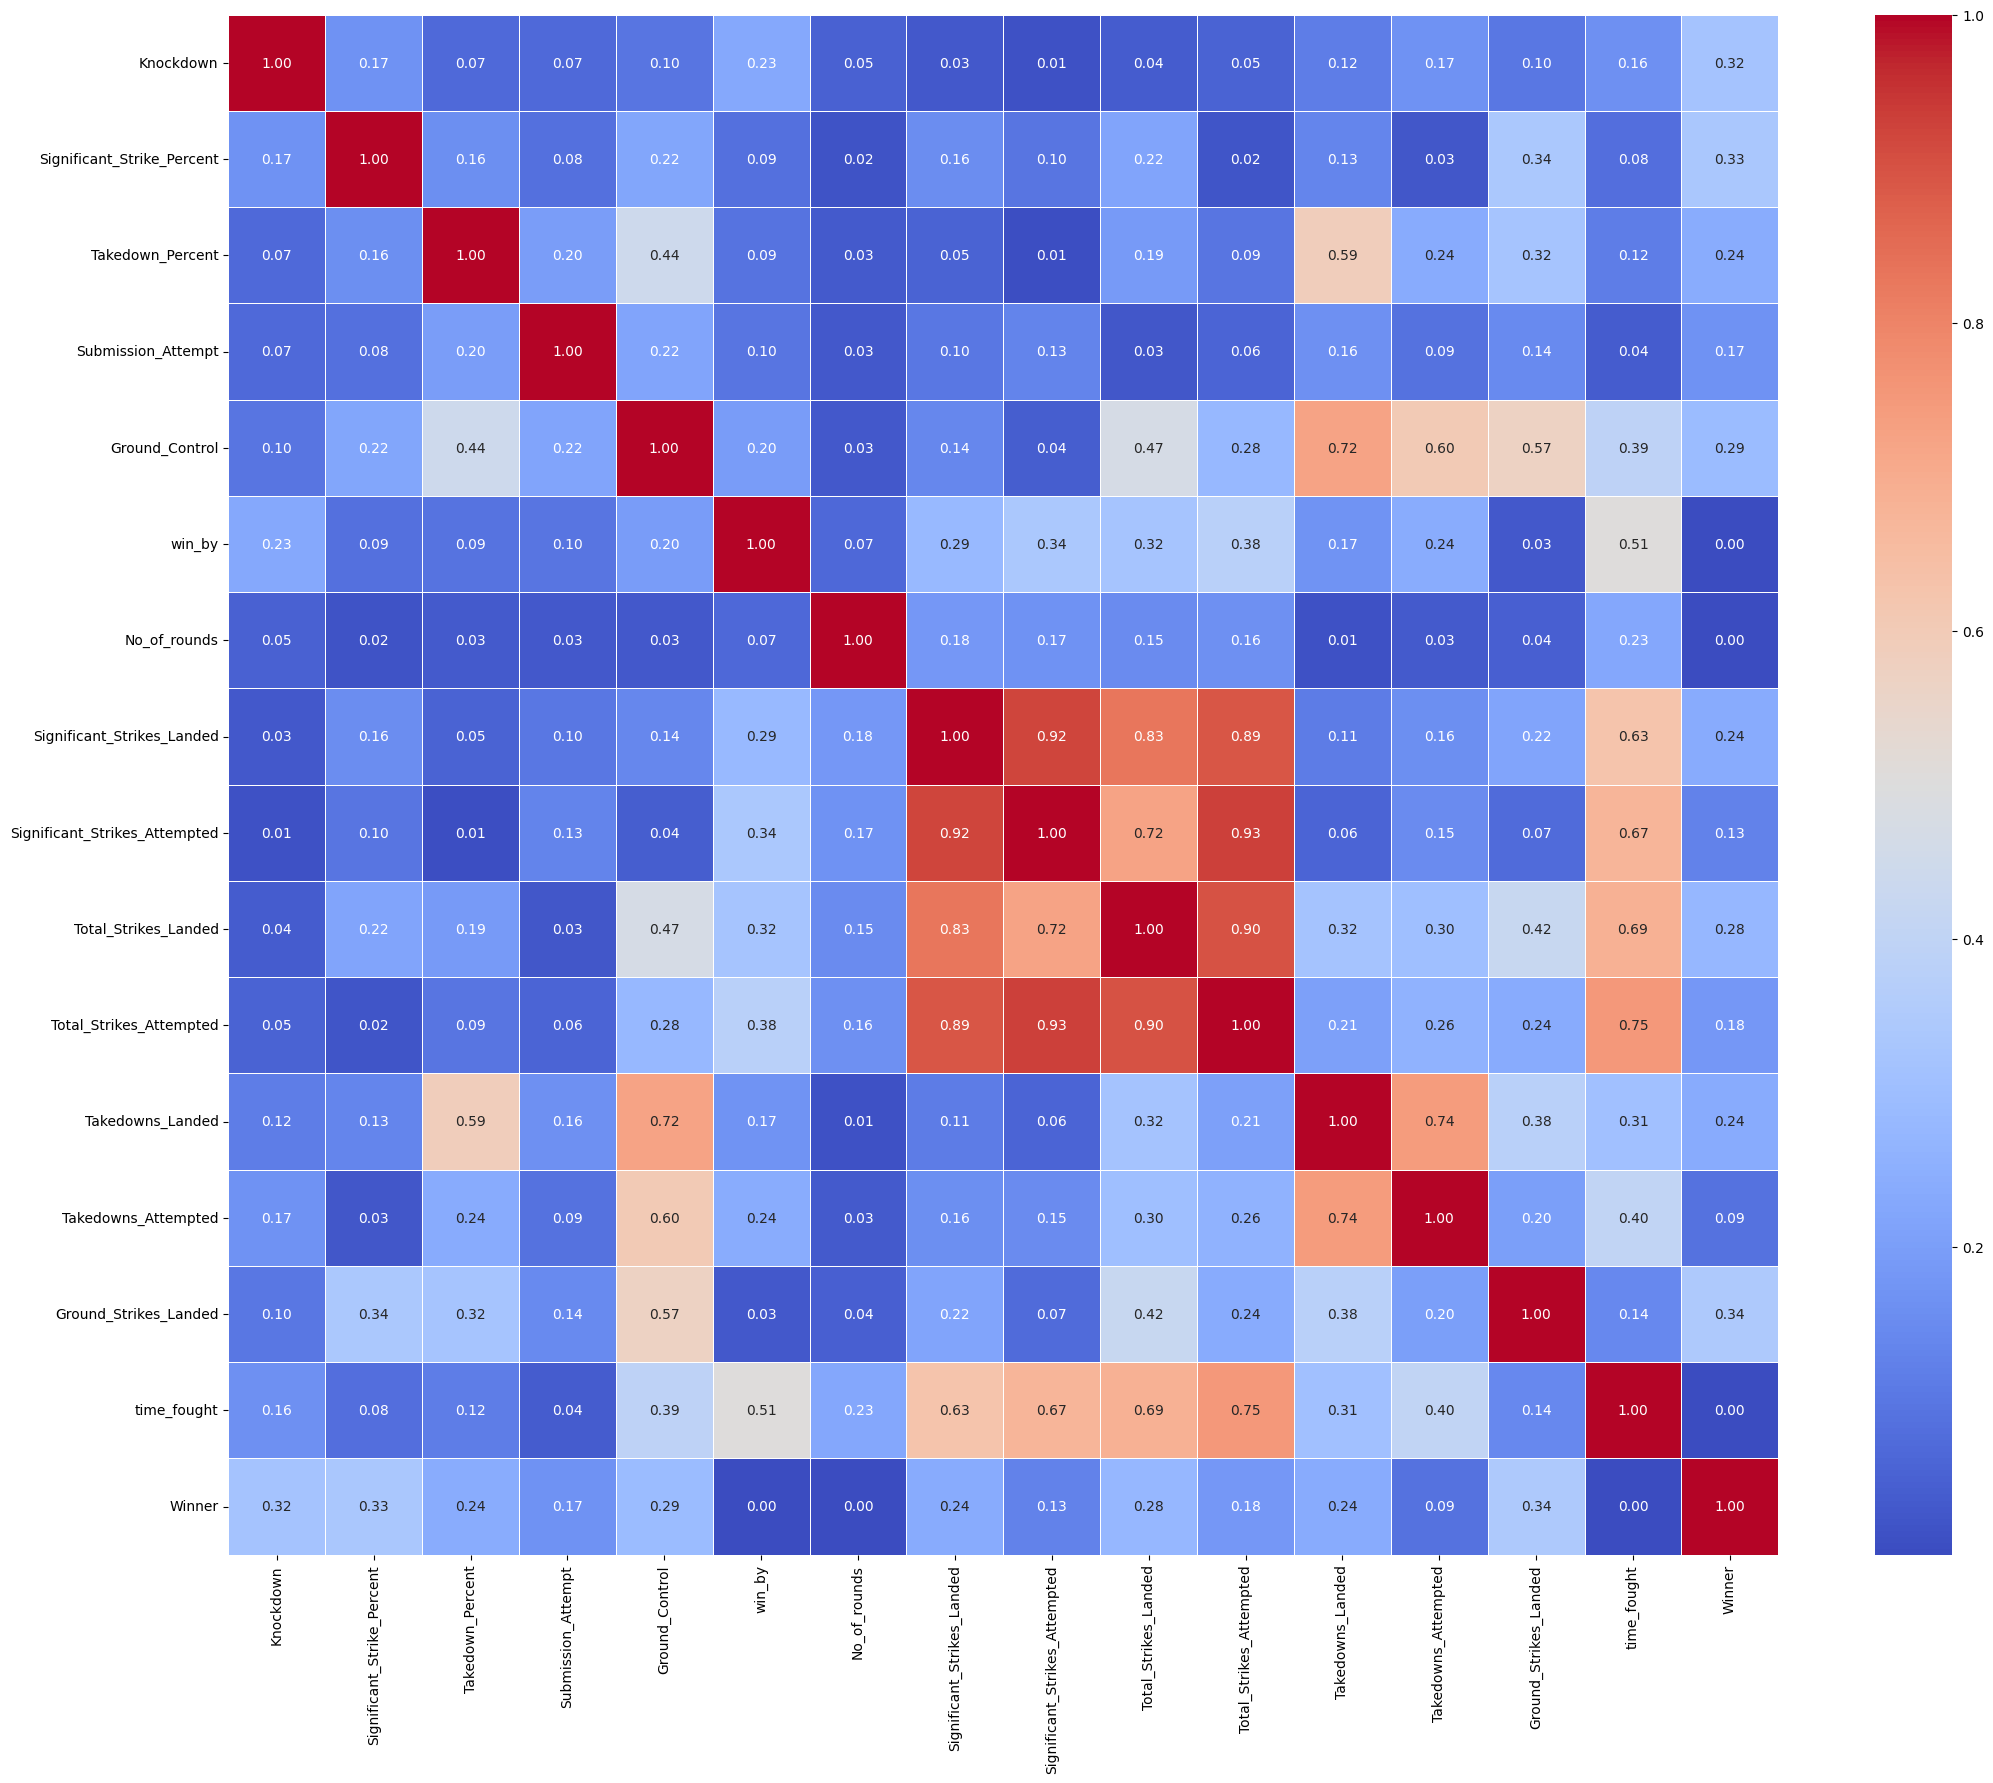

In [738]:
plt.figure(figsize=(25, 20))
corr_matrix = ufc.corr(method='pearson', numeric_only=True).abs()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)


In [739]:
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1)
                 .astype(bool))  # Use `bool` instead of `np.bool`
                 .stack()
                 .sort_values(ascending=False))

# Print the top 10 highest correlations
print(sol[0:10])

Significant_Strikes_Attempted  Total_Strikes_Attempted          0.931496
Significant_Strikes_Landed     Significant_Strikes_Attempted    0.921908
Total_Strikes_Landed           Total_Strikes_Attempted          0.901869
Significant_Strikes_Landed     Total_Strikes_Attempted          0.892021
                               Total_Strikes_Landed             0.828994
Total_Strikes_Attempted        time_fought                      0.750581
Takedowns_Landed               Takedowns_Attempted              0.742948
Significant_Strikes_Attempted  Total_Strikes_Landed             0.722919
Ground_Control                 Takedowns_Landed                 0.722893
Total_Strikes_Landed           time_fought                      0.685230
dtype: float64


In [740]:
ufc.isna().sum()

fighter                          0
Knockdown                        0
Significant_Strike_Percent       0
Takedown_Percent                 0
Submission_Attempt               0
Ground_Control                   0
win_by                           0
No_of_rounds                     0
date                             0
Fight_type                       0
Significant_Strikes_Landed       0
Significant_Strikes_Attempted    0
Total_Strikes_Landed             0
Total_Strikes_Attempted          0
Takedowns_Landed                 0
Takedowns_Attempted              0
Ground_Strikes_Landed            0
time_fought                      0
Winner                           0
dtype: int64

Need to create a gender column, to separate women and men's weight divisions

create a new column 'gender' in dataframe, and If column 'Fight_type' is W Strawweight or W Flyweight or W Bantamweight or W Featherweight, put the value 0 else make it 1.

In [741]:
def assign_gender(row):
    women_weights = ['W Strawweight', 'W Flyweight', 'W Bantamweight', 'W Featherweight']
    if row['Fight_type'] in women_weights:
        return 0
    else:
        return 1

In [742]:
ufc.insert(len(ufc.columns) - 1, 'Gender', ufc.apply(assign_gender, axis=1))

Removing all catch weight fights, because of convenience.

In [743]:
ufc = ufc[ufc['Fight_type'] != 'Catch Weight']

Changing weight division from names to numbers, so the model can process it.

In [744]:
mapping = {
    'W Strawweight': 115,
    'W Flyweight': 125,
    'W Bantamweight': 135,
    'W Featherweight': 145,
    'Flyweight': 125,
    'Bantamweight': 135,
    'Featherweight': 145,
    'Lightweight': 155,
    'Welterweight': 170,
    'Middleweight': 185,
    'Light Heavyweight': 205,
    'Heavyweight': 265,
}
pd.set_option('future.no_silent_downcasting', True)
ufc['Fight_type'] = ufc['Fight_type'].replace(mapping)

In [745]:
ufc.rename(columns={'Fight_type': 'Weight Division'}, inplace=True)

In [746]:
ufc.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Weight Division,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender,Winner
0,Themba Gorimbo,0,53,77,2,554,9,3,2024-10-12,170,68,127,141,223,7,9,19,900,1,1
1,CJ Vergara,0,25,0,0,0,10,3,2024-10-12,125,4,16,4,16,0,0,0,170,1,0
2,Cory McKenna,0,32,16,0,320,7,3,2024-10-12,115,40,124,98,198,1,6,0,900,0,0
3,Cody Haddon,0,50,50,0,91,9,3,2024-10-12,135,140,280,148,288,2,4,0,900,1,1
4,Sean Sharaf,0,44,12,0,46,10,3,2024-10-12,265,53,118,54,122,1,8,8,435,1,0


In [747]:
date_column = ufc['date']  # Extract the 'date' column
ufc.drop(columns=['date'], inplace=True)  # Remove the 'date' column from its current position
ufc.insert(0, 'date', date_column)  # Insert the 'date' column at the first position


In [748]:
ufc.describe()

,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender,Winner
count,14750.000000,14750.000000,14750.000000,14750.000000,14750.000000,14750.000000,14750.000000,14750.000000,14750.000000,14750.000000,14750.000000,14750.000000,14750.000000,14750.000000,14750.000000,14750.000000,14750.000000
mean,0.218305,45.311797,26.460542,0.384068,134.324475,9.111593,3.179797,37.317695,83.951525,55.339458,104.578441,1.073220,2.858847,4.950237,641.901831,0.893424,0.499797
std,0.496039,16.453142,35.142568,0.830681,174.636851,0.845608,0.572091,32.272760,70.587395,44.228474,78.512452,1.697651,3.750364,9.056409,360.758682,0.308584,0.500017
min,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000
25%,0.000000,35.000000,0.000000,0.000000,6.000000,9.000000,3.000000,13.000000,29.000000,20.000000,39.000000,0.000000,0.000000,0.000000,287.250000,1.000000,0.000000
50%,0.000000,45.000000,0.000000,0.000000,60.000000,9.000000,3.000000,29.000000,67.000000,47.000000,93.000000,0.000000,1.000000,1.000000,853.000000,1.000000,0.000000
75%,0.000000,55.000000,50.000000,0.000000,199.000000,10.000000,3.000000,53.000000,121.000000,80.000000,153.000000,2.000000,4.000000,6.000000,900.000000,1.000000,1.000000
max,5.000000,100.000000,100.000000,10.000000,1342.000000,10.000000,5.000000,445.000000,744.000000,447.000000,746.000000,21.000000,49.000000,136.000000,1500.000000,1.000000,1.000000


In [749]:
ufc.head()

,date,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,Weight Division,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender,Winner
0,2024-10-12,Themba Gorimbo,0,53,77,2,554,9,3,170,68,127,141,223,7,9,19,900,1,1
1,2024-10-12,CJ Vergara,0,25,0,0,0,10,3,125,4,16,4,16,0,0,0,170,1,0
2,2024-10-12,Cory McKenna,0,32,16,0,320,7,3,115,40,124,98,198,1,6,0,900,0,0
3,2024-10-12,Cody Haddon,0,50,50,0,91,9,3,135,140,280,148,288,2,4,0,900,1,1
4,2024-10-12,Sean Sharaf,0,44,12,0,46,10,3,265,53,118,54,122,1,8,8,435,1,0


In [750]:
ufc2 = ufc.copy()
ufc2.head()

# List of values to remove
values_to_remove = [
    'Road To    Bantamweight',
    'Road To    Featherweight',
    'Road To    Lightweight',
    'Road to    Flyweight'
]

# Remove rows with these values
ufc2 = ufc2[~ufc2['Weight Division'].isin(values_to_remove)]

# Convert 'Weight Division' to numeric
ufc2['Weight Division'] = pd.to_numeric(ufc2['Weight Division'])

# Verify the changes
print("Unique values in 'Weight Division' after cleaning:")
print(ufc2['Weight Division'].unique())
print("\nData type of 'Weight Division' after cleaning:", ufc2['Weight Division'].dtype)

# Print the new shape of the dataframe
print("\nNew shape of the dataframe:", ufc2.shape)

Unique values in 'Weight Division' after cleaning:
[170 125 115 135 265 155 145 185 205]

Data type of 'Weight Division' after cleaning: int64

New shape of the dataframe: (14742, 20)


# **Standardization**

In [751]:
print(ufc2.columns[2:-1].tolist())

['Knockdown', 'Significant_Strike_Percent', 'Takedown_Percent', 'Submission_Attempt', 'Ground_Control', 'win_by', 'No_of_rounds', 'Weight Division', 'Significant_Strikes_Landed', 'Significant_Strikes_Attempted', 'Total_Strikes_Landed', 'Total_Strikes_Attempted', 'Takedowns_Landed', 'Takedowns_Attempted', 'Ground_Strikes_Landed', 'time_fought', 'Gender']


In [752]:
def calculate_avg_attributes(dataframe, years):
    df_temp = dataframe.sort_values('date', ascending=False)  # Sort by date in descending order

    grouped_df = df_temp.groupby('fighter').head(years)  # Select up to 'years' number of rows for each fighter

    exclude_columns = ['Weight Division', 'Gender']
    avg_attributes = grouped_df.groupby('fighter').apply(lambda x: x.mean(numeric_only=True) if len(x) > 0 else pd.Series())
    
    # Update 'Weight Division' and 'Gender' columns with the last (latest) value
    last_values = grouped_df.groupby('fighter')[exclude_columns].last()
    avg_attributes[exclude_columns] = last_values
    
    avg_attributes = avg_attributes.reset_index()
    return avg_attributes


In [753]:
columns_to_standardize = ufc2.columns[2:-1].tolist()

scaler = StandardScaler()
scaler.fit(ufc2[columns_to_standardize])

ufc2[columns_to_standardize] = scaler.transform(ufc2[columns_to_standardize])

In [754]:
ufc2.head()

,date,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,Weight Division,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender,Winner
0,2024-10-12,Themba Gorimbo,-0.440068,0.467263,1.437710,1.945700,2.403375,-0.132084,-0.314384,0.051423,0.950323,0.609504,1.936342,1.507896,3.491217,1.638691,1.551537,0.715318,0.345488,1
1,2024-10-12,CJ Vergara,-0.440068,-1.234415,-0.753070,-0.462352,-0.769150,1.050895,-0.314384,-1.131848,-1.032495,-0.962803,-1.160867,-1.128311,-0.632217,-0.762632,-0.546668,-1.308214,0.345488,0
2,2024-10-12,Cory McKenna,-0.440068,-0.808995,-0.297843,-0.462352,1.063355,-2.498042,-0.314384,-1.394797,0.082840,0.567010,0.964225,1.189514,-0.043155,0.838250,-0.546668,0.715318,-2.894454,0
3,2024-10-12,Cody Haddon,-0.440068,0.284940,0.669514,-0.462352,-0.248032,-0.132084,-0.314384,-0.868899,3.180993,2.776740,2.094593,2.335691,0.545907,0.304622,-0.546668,0.715318,0.345488,1
4,2024-10-12,Sean Sharaf,-0.440068,-0.079705,-0.411650,-0.462352,-0.505728,1.050895,-0.314384,2.549440,0.485600,0.482020,-0.030499,0.221631,-0.043155,1.371877,0.336786,-0.573644,0.345488,0


In [755]:
# Define the path where the scaler will be saved
SCALER_PATH = './models/scaler.joblib'  # You can change the path as needed

# Ensure the 'models' directory exists
import os
os.makedirs(os.path.dirname(SCALER_PATH), exist_ok=True)

# Save the scaler
joblib.dump(scaler, SCALER_PATH)

print(f"Scaler successfully saved to {SCALER_PATH}")

Scaler successfully saved to ./models/scaler.joblib


In [756]:
with open('./data/raw_total_fight_data.csv', 'r') as file:
    for _ in range(5):
        line = file.readline()
        print(line)

R_fighter;B_fighter;R_KD;B_KD;R_SIG_STR.;B_SIG_STR.;R_SIG_STR_pct;B_SIG_STR_pct;R_TOTAL_STR.;B_TOTAL_STR.;R_TD;B_TD;R_TD_pct;B_TD_pct;R_SUB_ATT;B_SUB_ATT;R_REV;B_REV;R_CTRL;B_CTRL;R_HEAD;B_HEAD;R_BODY;B_BODY;R_LEG;B_LEG;R_DISTANCE;B_DISTANCE;R_CLINCH;B_CLINCH;R_GROUND;B_GROUND;win_by;last_round;last_round_time;Format;Referee;date;location;Fight_type;Winner

Themba Gorimbo;Niko Price;0;0;68 of 127;16 of 53;53%;30%;141 of 223;58 of 100;7 of 9;0 of 3;77%;0%;2;1;0;0;9:14;1:00;44 of 97;13 of 43;9 of 15;2 of 5;15 of 15;1 of 5;43 of 85;11 of 48;6 of 13;5 of 5;19 of 29;0 of 0;Decision - Unanimous;3;5:00;3 Rnd (5-5-5);Herb Dean;October 12, 2024;Las Vegas, Nevada, USA;Welterweight Bout;Themba Gorimbo

CJ Vergara;Ramazan Temirov;0;3;4 of 16;23 of 55;25%;41%;4 of 16;23 of 55;0 of 0;0 of 0;---;---;0;0;0;0;0:00;0:05;1 of 12;18 of 46;1 of 1;4 of 8;2 of 3;1 of 1;4 of 16;20 of 50;0 of 0;0 of 0;0 of 0;3 of 5;KO/TKO;1;2:50;3 Rnd (5-5-5);Jason Herzog;October 12, 2024;Las Vegas, Nevada, USA;Flyweight Bout;

# **Train Test Split**

In [757]:
X = ufc2.iloc[:, 2:-1].values
y = ufc2.iloc[:, -1].values

In [758]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# **Logistic Regression Model**

In [759]:
from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression(random_state = 0)
lr_classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [760]:
y_pred = lr_classifier.predict(X_test)
print(y_pred)

[0 0 0 ... 1 0 1]


In [761]:
new_y_pred = y_pred.reshape(len(y_pred),1)
new_y_test = y_test.reshape(len(y_test),1)
np.concatenate((new_y_pred,new_y_test),1)

array([[0, 1],
       [0, 1],
       [0, 0],
       ...,
       [1, 1],
       [0, 0],
       [1, 0]])

In [762]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(y_test, y_pred)
cm1 = confusion_matrix(y_pred, y_test)
print(cm1)
print(accuracy_score(y_test, y_pred))

[[1232  354]
 [ 241 1122]]
0.7982366904035266


# **Random Forest Model**

In [763]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 0)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=50, random_state=0)

In [764]:
y_pred = rf_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [0 1]
 [0 0]
 ...
 [1 1]
 [0 0]
 [1 0]]


In [765]:
cm2 = confusion_matrix(y_test, y_pred)
print(cm2)
accuracy_score(y_test, y_pred)

[[1242  231]
 [ 253 1223]]


0.8358765683282469

# **Decision Tree Model**

In [766]:
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(criterion = 'gini', random_state = 0)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [767]:
y_pred = dt_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [1 1]
 [0 0]
 ...
 [1 1]
 [0 0]
 [1 0]]


In [768]:
cm3 = confusion_matrix(y_test, y_pred)
print(cm3)
accuracy_score(y_test, y_pred)

[[1188  285]
 [ 362 1114]]


0.7806035944387928

# **Naive Bayes Model**

In [769]:
from sklearn.naive_bayes import GaussianNB
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [770]:
y_pred = nb_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 1]
 [0 1]
 [0 0]
 ...
 [1 1]
 [0 0]
 [1 0]]


In [771]:
cm4 = confusion_matrix(y_test, y_pred)
print(cm4)
accuracy_score(y_test, y_pred)

[[1220  253]
 [ 512  964]]


0.7405900305188199

# **KNN Model**

In [772]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

# n_neighbours = number of neighbours, metric = & = =2 to take euclidean distance
# euclidean distance is basically the geometric distance between 2 points
# p =1 = some other method under minkowski

knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [773]:
y_pred = knn_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [0 1]
 [0 0]
 ...
 [1 1]
 [0 0]
 [1 0]]


In [774]:
cm5 = confusion_matrix(y_test, y_pred)
print(cm5)
accuracy_score(y_test, y_pred)

[[1208  265]
 [ 294 1182]]


0.8104442183791115

# **SVM Model**

In [775]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel = 'linear', random_state = 0)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

In [776]:
y_pred = svm_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 1]
 [0 1]
 [0 0]
 ...
 [1 1]
 [0 0]
 [1 0]]


In [777]:
cm6 = confusion_matrix(y_test, y_pred)
print(cm6)
accuracy_score(y_test, y_pred)

[[1238  235]
 [ 357 1119]]


0.799253984401492

# **Prediction System**

In [778]:
ufc3 = ufc2.copy()

In [779]:
to_drop = ['Winner']


In [780]:
ufc3 = ufc3.drop(to_drop, axis=1)

In [781]:
ufc3.head()

,date,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,Weight Division,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender
0,2024-10-12,Themba Gorimbo,-0.440068,0.467263,1.437710,1.945700,2.403375,-0.132084,-0.314384,0.051423,0.950323,0.609504,1.936342,1.507896,3.491217,1.638691,1.551537,0.715318,0.345488
1,2024-10-12,CJ Vergara,-0.440068,-1.234415,-0.753070,-0.462352,-0.769150,1.050895,-0.314384,-1.131848,-1.032495,-0.962803,-1.160867,-1.128311,-0.632217,-0.762632,-0.546668,-1.308214,0.345488
2,2024-10-12,Cory McKenna,-0.440068,-0.808995,-0.297843,-0.462352,1.063355,-2.498042,-0.314384,-1.394797,0.082840,0.567010,0.964225,1.189514,-0.043155,0.838250,-0.546668,0.715318,-2.894454
3,2024-10-12,Cody Haddon,-0.440068,0.284940,0.669514,-0.462352,-0.248032,-0.132084,-0.314384,-0.868899,3.180993,2.776740,2.094593,2.335691,0.545907,0.304622,-0.546668,0.715318,0.345488
4,2024-10-12,Sean Sharaf,-0.440068,-0.079705,-0.411650,-0.462352,-0.505728,1.050895,-0.314384,2.549440,0.485600,0.482020,-0.030499,0.221631,-0.043155,1.371877,0.336786,-0.573644,0.345488


**Approach and Assumptions**

Now, to make a prediction IRL, I will only have 'names' of the fighters', but our model requires all other attributes as well. So what I am doing is, taking the mean value of all other attributes from a fighter's last 3 fights, as I feel like it's a good reflection of how the fighter is doing at any given point. If the fighter does not have 3 fights already in the UFC, I'll take mean of 2 fights, and if even that is not there then I will go with the values of just there first fight. 

In [782]:
ufc3.columns.tolist()

['date',
 'fighter',
 'Knockdown',
 'Significant_Strike_Percent',
 'Takedown_Percent',
 'Submission_Attempt',
 'Ground_Control',
 'win_by',
 'No_of_rounds',
 'Weight Division',
 'Significant_Strikes_Landed',
 'Significant_Strikes_Attempted',
 'Total_Strikes_Landed',
 'Total_Strikes_Attempted',
 'Takedowns_Landed',
 'Takedowns_Attempted',
 'Ground_Strikes_Landed',
 'time_fought',
 'Gender']

In [783]:
def calculate_avg_attributes(dataframe, years):
    df_temp = dataframe.sort_values('date', ascending=False)  # Sort by date in descending order

    grouped_df = df_temp.groupby('fighter').head(years)  # Select up to 'years' number of rows for each fighter

    exclude_columns = ['Weight Division', 'Gender']
    avg_attributes = grouped_df.groupby('fighter').apply(lambda x: x.mean(numeric_only=True) if len(x) > 0 else pd.Series())
    
    # Update 'Weight Division' and 'Gender' columns with the last (latest) value
    last_values = grouped_df.groupby('fighter')[exclude_columns].last()
    avg_attributes[exclude_columns] = last_values
    
    avg_attributes = avg_attributes.reset_index()
    return avg_attributes


In [784]:
avg_attributes_df = calculate_avg_attributes(ufc3, 3)

/var/folders/gy/n2hps2kd1kg7ng24xwgchvhr0000gn/T/ipykernel_2006/346538165.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_attributes = grouped_df.groupby('fighter').apply(lambda x: x.mean(numeric_only=True) if len(x) > 0 else pd.Series())


In [785]:
# Define the output path for the cleaned CSV
CLEANED_DATA_PATH = './data/avg_attributes.csv'  # You can change the path as needed

# Export the cleaned DataFrame to CSV
avg_attributes_df.to_csv(CLEANED_DATA_PATH, index=False)

In [786]:
avg_attributes_df.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,Weight Division,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender
0,Alatengheili,0.232140,-0.383576,0.242739,-0.462352,0.561325,-0.526410,-0.314384,-0.868899,-0.392210,-0.212062,0.165432,0.196160,0.742261,0.749312,-0.399426,-0.072843,0.345488
1,Aoriqileng,0.904348,0.831908,0.669514,-0.462352,0.061204,0.262242,-0.314384,-0.868899,0.423637,0.047629,0.790902,0.395680,-0.043155,-0.051129,0.925756,0.038959,0.345488
2,Maheshate,1.576557,0.254553,-0.753070,-0.462352,-0.769150,1.050895,-0.314384,-0.343000,-0.552281,-0.346629,-0.799149,-0.567958,-0.632217,-0.495819,-0.546668,-1.043492,0.345488
3,Mizuki,-0.440068,0.406489,0.669514,-0.462352,0.439158,-0.132084,-0.314384,-1.394797,0.547563,0.297876,0.625115,0.450866,-0.043155,-0.229005,-0.436237,0.715318,-2.894454
4,Rongzhu,0.232140,0.406489,0.195319,-0.462352,0.374257,0.262242,-0.314384,-0.343000,0.733452,0.467855,0.497006,0.433886,0.742261,0.304622,1.036188,0.187721,0.345488


In [787]:
def get_fighter_row(dataframe, fighter_name):
    row = dataframe.loc[dataframe['fighter'] == fighter_name]
    row_values = row.values.flatten()[1:]  # Exclude the 'fighter' column
    return row_values

Since **Random Forest** had the best results, I am taking it to make calculate the probability of a fighter winning their next fight.

In [788]:
def get_win_probability(fighter_name):
    fighter_name = fighter_name
    fighter_row = get_fighter_row(avg_attributes_df, fighter_name)
    win_prob = rf_classifier.predict_proba([fighter_row])[0][1]
    return win_prob

**Add name of a fighter to get the probability of them winning their next fight.**


In [789]:
get_win_probability("Sean Strickland")

np.float64(0.68)

In [790]:
def match_probability(fighter_A, fighter_B):
    fighter_A = fighter_A
    fighter_B = fighter_B
    prob_A = get_win_probability(fighter_A)
    prob_B = get_win_probability(fighter_B)
    total_prob = prob_A + prob_B
    probability_A = round(prob_A / total_prob, 2)
    probability_B = round(prob_B / total_prob, 2)
    return probability_A, probability_B


Add 2 names here.

In [791]:
match_probability('Jon Jones', "Stipe Miocic")

(np.float64(0.33), np.float64(0.67))

In [792]:
import joblib
import os

# Define the models directory
models_dir = './models/'
os.makedirs(models_dir, exist_ok=True)

# Save Logistic Regression model
lr_model_path = os.path.join(models_dir, 'lr_model.joblib')
joblib.dump(lr_classifier, lr_model_path)
print(f"Logistic Regression model saved to {lr_model_path}")

# Save Random Forest model
rf_model_path = os.path.join(models_dir, 'rf_model.joblib')
joblib.dump(rf_classifier, rf_model_path)
print(f"Random Forest model saved to {rf_model_path}")

# Save Decision Tree model
dt_model_path = os.path.join(models_dir, 'dt_model.joblib')
joblib.dump(dt_classifier, dt_model_path)
print(f"Decision Tree model saved to {dt_model_path}")

# Save Naive Bayes model
nb_model_path = os.path.join(models_dir, 'nb_model.joblib')
joblib.dump(nb_classifier, nb_model_path)
print(f"Naive Bayes model saved to {nb_model_path}")

# Save KNN model
knn_model_path = os.path.join(models_dir, 'knn_model.joblib')
joblib.dump(knn_classifier, knn_model_path)
print(f"KNN model saved to {knn_model_path}")

# Save SVM model
svm_model_path = os.path.join(models_dir, 'svm_model.joblib')
joblib.dump(svm_classifier, svm_model_path)
print(f"SVM model saved to {svm_model_path}")

Logistic Regression model saved to ./models/lr_model.joblib
Random Forest model saved to ./models/rf_model.joblib
Decision Tree model saved to ./models/dt_model.joblib
Naive Bayes model saved to ./models/nb_model.joblib
KNN model saved to ./models/knn_model.joblib
SVM model saved to ./models/svm_model.joblib


In [794]:
import json
import os

CLEANED_DATA_PATH = './data/avg_attributes.csv'

required_columns = ['Gender', 'fighter']
missing_columns = [col for col in required_columns if col not in avg_attributes_df.columns]

if missing_columns:
    print(f"Error: The following required columns are missing in the DataFrame: {missing_columns}")
    exit(1)
else:
    print("\nBoth 'Gender' and 'fighter' columns are present.")

female_fighters_df = avg_attributes_df[avg_attributes_df['Gender'] < 0]
male_fighters_df = avg_attributes_df[avg_attributes_df['Gender'] > 0]  # Changed from >= 0 to > 0

female_fighters = female_fighters_df['fighter'].drop_duplicates().sort_values().tolist()
male_fighters = male_fighters_df['fighter'].drop_duplicates().sort_values().tolist()

print("\nSample Female Fighters:", female_fighters[:5])
print("Sample Male Fighters:", male_fighters[:5])

FEMALE_FIGHTERS_JSON_PATH = './data/female_fighters.json'
MALE_FIGHTERS_JSON_PATH = './data/male_fighters.json'

def export_fighters_to_json(fighter_list, json_path):
    """
    Exports a list of fighter names to a JSON file.
    
    Parameters:
    - fighter_list (list): List of fighter names.
    - json_path (str): Path to save the JSON file.
    """
    try:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        
        # Export to JSON
        with open(json_path, 'w') as json_file:
            json.dump(fighter_list, json_file, indent=4)
        
        print(f"Fighter names successfully exported to {json_path}")
    except Exception as e:
        print(f"An error occurred while exporting to {json_path}: {e}")

export_fighters_to_json(female_fighters, FEMALE_FIGHTERS_JSON_PATH)
export_fighters_to_json(male_fighters, MALE_FIGHTERS_JSON_PATH)


Both 'Gender' and 'fighter' columns are present.

Sample Female Fighters: [' Mizuki', 'Ailin Perez', 'Aisling Daly', 'Aleksandra Albu', 'Alex Chambers']
Sample Male Fighters: [' Alatengheili', ' Aoriqileng', ' Maheshate', ' Rongzhu', ' Sumudaerji']
Fighter names successfully exported to ./data/female_fighters.json
Fighter names successfully exported to ./data/male_fighters.json
